# Binned FWC and SIC distribution

In [1]:
## import required packages
import numpy as np
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import cmocean
import gsw
import matplotlib.dates as mdates
import time
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45187")
client

<Client: 'tcp://127.0.0.1:45187' processes=8 threads=32, memory=123.95 GiB>

**PROCEDURE:**

1. Select days after sea ice minimum each year.
2. Mask grid cells where SIC>15% at minimum.
3. Calculate FWC in each grid cell, then bin grid cells.
4. For each FWC bin and timestep, compute mean SIC.

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [5]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

### Open daily mean ZARR datasets

In [6]:
# open SALT zarr store - [psu]
salt_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options).SALT

# open THETA zarr store - [degC]
theta_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options).THETA

# open SIarea zarr store - [fraction of sea ice, 0 to 1]
ice_da = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SIarea_AVG_DAILY.ZARR/', s3_options).SIarea*100

In [7]:
# carve out beaufort region
salt_beaufort = salt_da.isel(i=slice(450,750),j=slice(110,390))
theta_beaufort = theta_da.isel(i=slice(450,750),j=slice(110,390))
ice_beaufort = ice_da.isel(i=slice(450,750),j=slice(110,390))

HH_grid_land = HH_grid.maskC.isel(k=0).where(HH_grid.maskC.isel(k=0)==0)
HH_land_beaufort = HH_grid_land.isel(i=slice(450,750),j=slice(110,390))

## 1. Select days after sea ice minimum each year and mask SIC>15%

In [8]:
ice_beaufort = ice_da.sel(time=slice('2014','2020')).isel(i=slice(450,750),j=slice(110,390))
beaufort_area = HH_grid.isel(i=slice(450,750),j=slice(110,390)).rAc

In [9]:
# calculating minimum based on extend (count grid cells where ice concentration >= 15% and sum their areas)

# salculate sea ice extent: sum the area of grid cells where SIC >= 15%
ice_extent = ((ice_beaufort >= 15) * beaufort_area).sum(dim=['i', 'j'])
ice_extent = ice_extent.where(ice_extent != 0)

# group by year
grouped = ice_extent.groupby("time.year")

# find the day of the minimum extent for each year
min_ice_dates = []
for year, data in grouped:
    sic_min_yr = data['time']
    min_day_tmp = sic_min_yr[data.argmin().values].values  # Get the time corresponding to min extent
    min_ice_dates.append(min_day_tmp)
    print(f"{year}: Minimum extent on {min_day_tmp}")

2014: Minimum extent on 2014-09-23T12:00:00.000000000
2015: Minimum extent on 2015-09-16T12:00:00.000000000
2016: Minimum extent on 2016-09-01T12:00:00.000000000
2017: Minimum extent on 2017-10-07T12:00:00.000000000
2018: Minimum extent on 2018-09-21T12:00:00.000000000
2019: Minimum extent on 2019-09-24T12:00:00.000000000
2020: Minimum extent on 2020-09-06T12:00:00.000000000


In [10]:
# generate daily timestamps from each min date to Dec 31 of that year
date_arrays = [np.arange(np.datetime64(date), np.datetime64(f"{str(date)[:4]}-12-31") + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
               for date in min_ice_dates]

# concatenate into one array
full_date_array = np.concatenate(date_arrays)

In [11]:
# select days after sea ice minimum for SIC and salinity

# select all timesteps after sea ice minimum each year
ice_yrs = ice_beaufort.sel(time=full_date_array)
salt_yrs = salt_beaufort.sel(time=full_date_array).isel(k=slice(0,7)) # only upper 10 m

In [12]:
# look at depth of grid cell center and bottom of grid cell
print(salt_yrs.Z.values)
print(HH_grid.isel(k_u=slice(0,7)).Zu.values)

[-0.5   -1.57  -2.79  -4.185 -5.78  -7.595 -9.66 ]
[ -1.    -2.14  -3.44  -4.93  -6.63  -8.56 -10.76]


In [13]:
# list to store yearly masks
mask_list = []

for date in min_ice_dates:
    year = str(date.astype('datetime64[Y]'))  # Extract year as a string
    
    # select all days from the minimum ice date to Dec 31
    yearly_data = ice_yrs.sel(time=slice(str(date), f"{year}-12-31"))

    # get sea ice concentration on the minimum ice date
    sic_min_day = ice_yrs.sel(time=date)

    # create a mask for grid cells where sic >= 15% on the minimum ice date
    mask = sic_min_day >= 15  # 2D (i, j)

    # expand mask along time dimension to match yearly_data
    mask_expanded = mask.expand_dims(dim={"time": yearly_data.time}, axis=0)

    # store in list
    mask_list.append(mask_expanded)

# combine all yearly masks
sic_yrs_mask = xr.concat(mask_list, dim="time").combine_first(ice_yrs * 0)  # Align time with ice_yrs

# apply mask to sea ice ds
land_sic_mask_yr = (~sic_yrs_mask.astype(bool)) & (HH_grid.isel(i=slice(450,750),j=slice(110,390),k=0).mask_basin)
ice_yrs_masked = ice_yrs.where(land_sic_mask_yr)

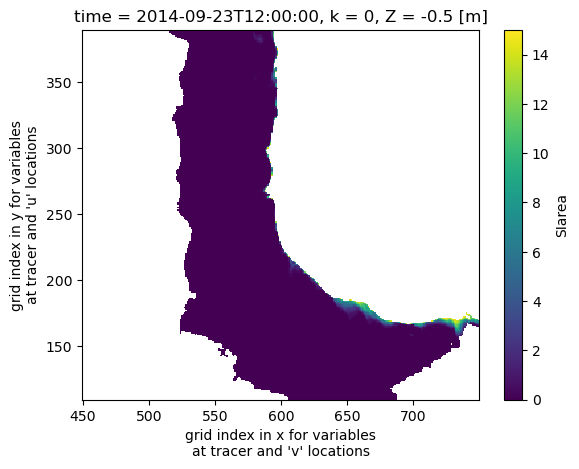

In [14]:
ice_yrs_masked.sel(time='2014').isel(time=0).plot();

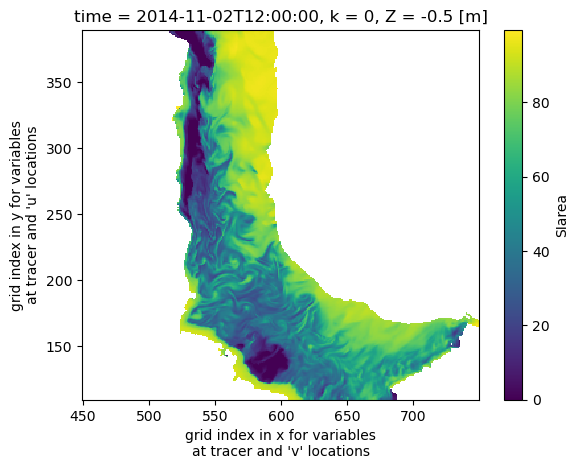

In [15]:
ice_yrs_masked.sel(time='2014').isel(time=40).plot();

## 2. Calculate FWC and bin data into 100 bins

In [16]:
def calculate_fwc(salt_da, salt_ref, dz):
    """
    Calculate the freshwater content (fwc)

    Parameters:
    salt_da (xr.DataArray): Salinity data array with a 'k' dimension.
    salt_ref (float): Reference salinity value.
    dz (xr.DataArray): Layer thickness data array with the same 'k' dimension.

    Returns:
    xr.DataArray: Freshwater content summed over the 'k' dimension.
    """
    fwc = ((salt_ref - salt_da) / salt_ref * dz).sum(dim='k')
    return fwc

In [17]:
# calculate FWC
# max S at 10 m
salt_ref = 34.0

# isolate grid cell thickness (dz) -----------
dz = HH_grid.isel(i=slice(450,750),j=slice(110,390)).drF.isel(k=slice(0,7)) # upper 10

# calcualte fwc -----------
fwc_beaufort_yrs = calculate_fwc(salt_yrs, salt_ref, dz)

In [18]:
# mask land grid cells and where SIC>15% on ice minimum date
fwc_yrs_masked = fwc_beaufort_yrs.where(land_sic_mask_yr)

In [19]:
# determine the upper end of the dataset
fwc_yrs_masked.max().values

array(6.66130379)

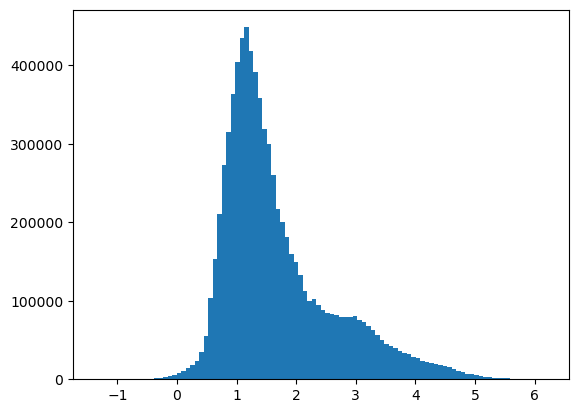

In [20]:
# look at histogram of FWC for a few years
plt.hist(np.ravel(fwc_yrs_masked.sel(time=slice('2014','2016')).values),100);

In [21]:
# define FWC bins
fwc_bins = np.linspace(0,6,99)
fwc_bins = np.append(fwc_bins, 7) # total of 100, the last bin is all FWC values between 5 and 7 m

In [22]:
len(fwc_bins)

100

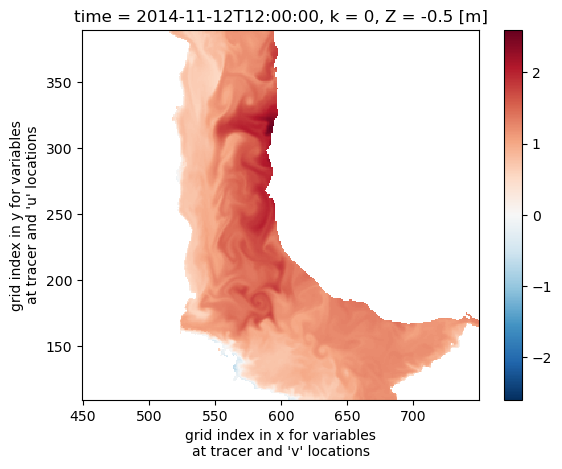

In [23]:
fwc_yrs_masked.isel(time=50).plot();

In [24]:
# bin each grid cell into FWC intervals
# use np.digitize to bin the values according to fwc_bins
fwc_binned_yrs = np.digitize(fwc_yrs_masked, fwc_bins, right=False)

In [25]:
fwc_binned_yrs.shape

(733, 280, 300)

In [26]:
# sanity check
print(fwc_binned_yrs[0,110,145]) # index = 60
print(fwc_bins[60]) # index provides the upper end of the bin interval
print(fwc_bins[59:61]) # upper and lower ends of the bin
print(fwc_yrs_masked.values[0,110,145]) # actual value from this grid cell, and it falls within the bin range - looks good!

60
3.673469387755102
[3.6122449  3.67346939]
3.6608541707431566


In [27]:
fwc_binned_da = xr.DataArray(data = fwc_binned_yrs, dims=['time', 'j', 'i'],\
                             coords={'time': fwc_yrs_masked.time.values, 'j': fwc_yrs_masked.j.values, 'i': fwc_yrs_masked.i.values})

In [28]:
# mask out land and sea ice
fwc_binned_da = fwc_binned_da.where(land_sic_mask_yr)

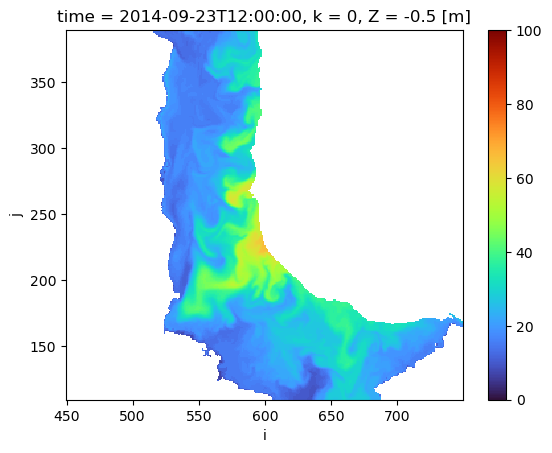

In [29]:
fwc_binned_da.isel(time=0).plot(vmin=0,vmax=100,cmap='turbo');

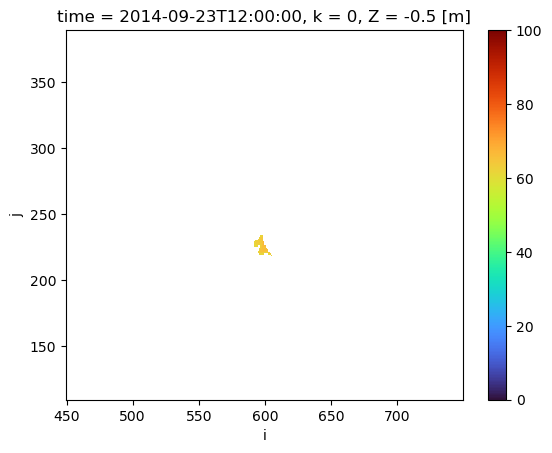

In [30]:
fwc_binned_da.isel(time=0).where((fwc_binned_da.isel(time=0)>60) & (fwc_binned_da.isel(time=0)<90)).plot(vmin=0,vmax=100,cmap='turbo');

In [31]:
ice_yrs_masked.shape

(733, 280, 300)

In [32]:
fwc_binned_da.shape

(733, 280, 300)

#### Save ZARR FWC datasets

In [36]:
fwc_beaufort_yrs = fwc_beaufort_yrs.where(HH_grid.isel(i=slice(450,750),j=slice(110,390),k=0).mask_basin)

In [37]:
fwc_beaufort_yrs.name = 'fwc'
fwc_beaufort_yrs.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_Beaufort_final.ZARR')

In [39]:
fwc_yrs_masked.name = 'fwc'
fwc_yrs_masked.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_masked_Beaufort_final.ZARR')

fwc_binned_da.name = 'fwc_bin'
fwc_binned_da.to_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_binned_final.ZARR')

## 3. Group by bins and calculate mean SIC for each bin for every time step

In [33]:
# open ZARR stores
ice_yrs_masked = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/SIC/SIC_masked_Beaufort.ZARR')
ice_yrs_masked = ice_yrs_masked.sic

fwc_binned_da = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_binned_final.ZARR')
fwc_binned_da = fwc_binned_da.fwc_bin

In [34]:
# define FWC bins
fwc_bins = np.linspace(0,6,99)
fwc_bins = np.append(fwc_bins, 7) # total of 100, the last bin is all FWC values between 5 and 7 m

In [35]:
# group by bins and calculate mean SIC
ice_grouped_mean = ice_yrs_masked.groupby(fwc_binned_da).mean(dim=['i','j'])

In [36]:
from matplotlib.colors import LinearSegmentedColormap

# Function to truncate colormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

In [37]:
# truncate the cmocean ice colormap to avoid very dark colors
trunc_ice = truncate_colormap(cmocean.cm.ice, minval=0.2, maxval=1.0)

In [38]:
def remap_colormap(cmap, nonlin_scale=np.sqrt, n=256):
    """
    Remap a colormap so that lower values are compressed (darker colors take up less space),
    and higher values (lighter colors) are stretched out.
    
    Parameters:
    - cmap: The original colormap (e.g., cmocean.cm.ice)
    - nonlin_scale: A function that maps [0,1] -> [0,1] nonlinearly (default: np.sqrt)
    - n: Number of color levels
    
    Returns:
    - A new colormap with redistributed colors.
    """
    # Generate linearly spaced values, then apply non-linear scaling
    orig_vals = np.linspace(0, 1, n)
    remapped_vals = nonlin_scale(orig_vals)

    # Normalize remapped values to stay in [0,1]
    remapped_vals = (remapped_vals - remapped_vals.min()) / (remapped_vals.max() - remapped_vals.min())

    # Map those values through the original colormap
    new_colors = cmap(remapped_vals)
    
    return LinearSegmentedColormap.from_list(f'remapped_{cmap.name}', new_colors, N=n)

In [39]:
# create a nonlinearly adjusted colormap from the cmocean ice colormap
custom_cmap = remap_colormap(cmocean.cm.ice, nonlin_scale=np.sqrt)  # sqrt compresses low end

### Mean SIC vs. Freshwater Content

In [41]:
from xarray.groupers import UniqueGrouper
from xarray.groupers import BinGrouper

In [42]:
# convert time to Day of Year (DOY)
doy = ice_yrs_masked['time'].dt.dayofyear

# add bins and doy as coordinates
ice_yrs_masked = ice_yrs_masked.assign_coords(bins=fwc_binned_da).assign_coords(doy=doy)

In [43]:
# group by DOY and FWC bin, then compute the mean across years
groups = ice_yrs_masked.groupby(bins=UniqueGrouper(),doy=UniqueGrouper())
# groups = ice_yrs_masked.groupby('time.dayofyear')

In [44]:
# check groups
groups

<DataArrayGroupBy, grouped over 2 grouper(s), 12200 groups in total:
    'bins': 100/100 groups present with labels 0.0, 1.0, 2.0, ..., 97.0, 98.0, 99.0
    'doy': 122/122 groups present with labels 245, 246, 247, ..., 364, 365, 366>

In [45]:
# then reduce by taking mean
ice_yrs_masked_mean = groups.mean()

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/flox/core.py:2368: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  result = result[..., sorted_idx]


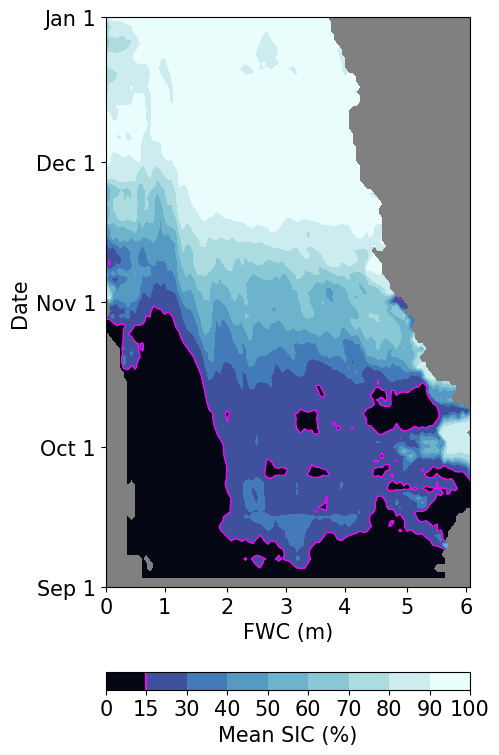

In [46]:
plt.rcParams['font.size'] = 15

# Create figure and axis
fig, ax = plt.subplots(figsize=(4.7, 10))

# Define contour levels
levels = [0, 15, 30, 40, 50, 60, 70, 80, 90, 100]

# Plot Hovmöller Diagram
cbar_plot = ice_yrs_masked_mean.plot.contourf(
    ax=ax, x='bins', y='doy', cmap=custom_cmap, levels=levels, add_colorbar=False
)
ax.set_facecolor('gray')

# Plot contour lines for sea ice concentration
ice_yrs_masked_mean.plot.contour(
    ax=ax, x='bins', y='doy', levels=[15], colors='magenta', linestyles='solid', linewidths=1
)

# Define y-tick positions and format as "Sep 1", "Oct 1", etc.
doy_ticks = [243, 273, 304, 334, 365]  # Approx: Sep 1, Oct 1, Nov 1, Dec 1, Dec 31
md_labels = [f"{mdates.num2date(d).strftime('%b')} {mdates.num2date(d).day}" for d in doy_ticks]

# Apply tick locations and labels to primary y-axis
ax.set_yticks(doy_ticks)
ax.set_yticklabels(md_labels)
ax.set_ylabel("Date")

# Configure x-axis
ax.set_xlabel("FWC (m)")
ax.set_xlim(0, 99)
ax.set_ylim(243, 365)
ax.set_title('')  # Optional: add a title here if needed

# Set x-axis tick labels based on bins
x_tick_indices = [0, np.argmin(abs(fwc_bins - 1)), np.argmin(abs(fwc_bins - 2)),
                  np.argmin(abs(fwc_bins - 3)), np.argmin(abs(fwc_bins - 4)),
                  np.argmin(abs(fwc_bins - 5)), np.argmin(abs(fwc_bins - 6))]
ax.set_xticks(x_tick_indices)
ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6'])

# Add horizontal colorbar below the plot
cbar = fig.colorbar(cbar_plot, orientation='horizontal', ax=ax, pad=0.11)
cbar.set_label("Mean SIC (%)")
cbar.ax.axvline(x=15, color='magenta', linewidth=1.5, linestyle='solid');

# Save the figure
plt.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/fig3.png',
            dpi=300, bbox_inches='tight')